In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Germany,India,US,China,Spain,Italy
0,2020-01-22,0,0,1,548,0,0
1,2020-01-23,0,0,1,643,0,0
2,2020-01-24,0,0,2,920,0,0
3,2020-01-25,0,0,2,1406,0,0
4,2020-01-26,0,0,5,2075,0,0


In [40]:
N0=100000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
I0=df_analyse.Germany[10]
S0=N0-I0
R0=0

In [41]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0           
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

# Simulative approach to calculate SIR curves

In [42]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(1000):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

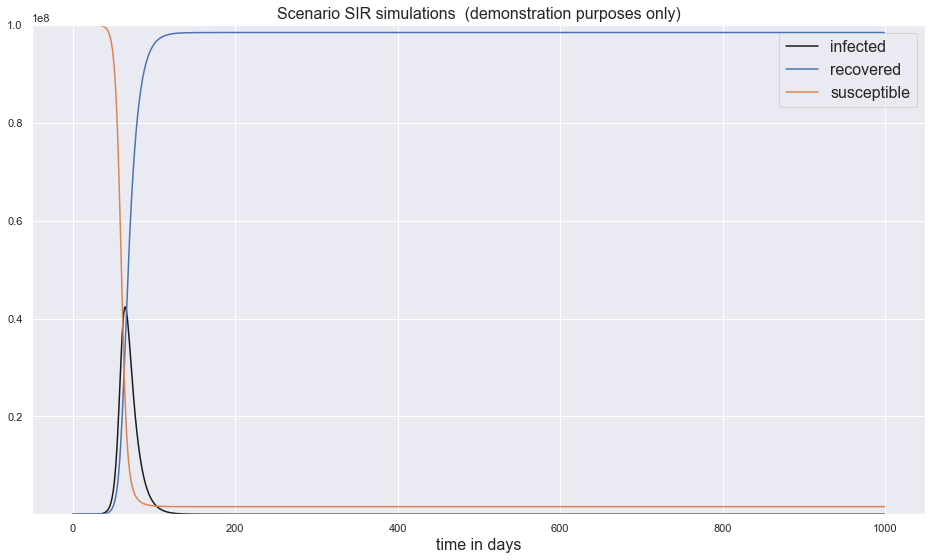

In [43]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 100000000)
ax1.set_yscale('linear')
ax1.set_title('Scenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting the parameters of SIR model

In [44]:
ydata = np.array(df_analyse.Germany[35:])
t=np.arange(len(ydata))

In [45]:
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [46]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [47]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [48]:
# example curve of our differential equationa
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([ 2.10000000e+01,  2.83470322e+01,  3.82644854e+01,  5.16516419e+01,
        6.97224033e+01,  9.41153622e+01,  1.27042380e+02,  1.71489145e+02,
        2.31485894e+02,  3.12472833e+02,  4.21793400e+02,  5.69360061e+02,
        7.68552996e+02,  1.03743311e+03,  1.40037922e+03,  1.89029783e+03,
        2.55160525e+03,  3.44425228e+03,  4.64915482e+03,  6.27552132e+03,
        8.47073737e+03,  1.14336974e+04,  1.54327801e+04,  2.08300753e+04,
        2.81140190e+04,  3.79433221e+04,  5.12060435e+04,  6.90989209e+04,
        9.32337131e+04,  1.25779397e+05,  1.69651668e+05,  2.28764308e+05,
        3.08360512e+05,  4.15445731e+05,  5.59346194e+05,  7.52416918e+05,
        1.01091634e+06,  1.35604529e+06,  1.81510560e+06,  2.42265331e+06,
        3.22138282e+06,  4.26226425e+06,  5.60316718e+06,  7.30489732e+06,
        9.42342175e+06,  1.19974036e+07,  1.50314652e+07,  1.84781142e+07,
        2.22244257e+07,  2.60914320e+07,  2.98520452e+07,  3.32662454e+07,
        3.61234196e+07,  

In [49]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

C:\Users\kaust\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-46-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-46-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-46-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
C:\Users\kaust\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [64.65359437 64.49818856]  start infect: 21
Optimal parameters: beta = 1.0034675881246484  and gamma =  0.9932768178338048


In [50]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

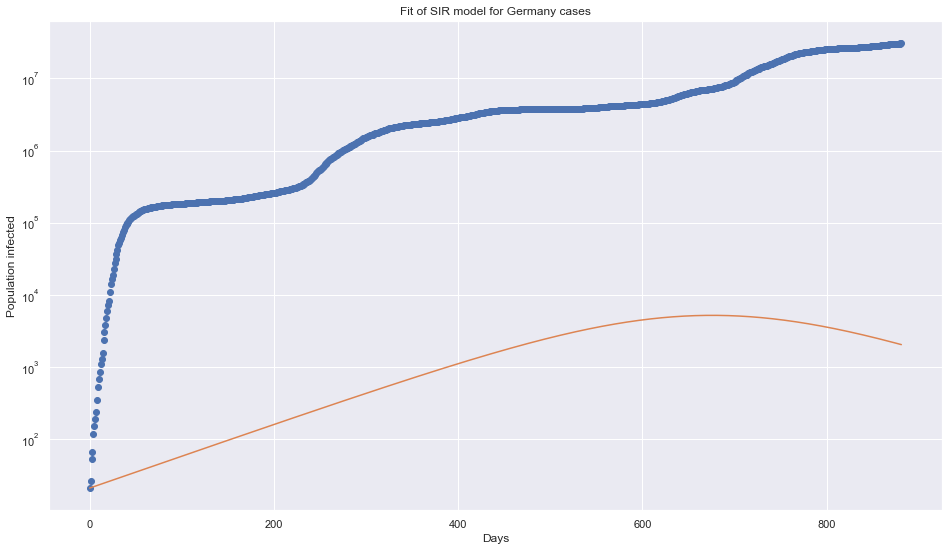

Optimal parameters: beta = 1.0034675881246484  and gamma =  0.9932768178338048
Basic Reproduction Number R0  1.010259748448643


In [51]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])

#print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in 

# Dynamic beta in SIR (infection rate)

In [52]:
t_initial=28
t_intro_measures=14
t_hold=21
t_relax=21

beta_max=0.4
beta_min=0.11
gamma=0.1
pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))

pd_beta

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.37769231,
       0.35538462, 0.33307692, 0.31076923, 0.28846154, 0.26615385,
       0.24384615, 0.22153846, 0.19923077, 0.17692308, 0.15461538,
       0.13230769, 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.1245    ,
       0.139     , 0.1535    , 0.168     , 0.1825    , 0.197     ,
       0.2115    , 0.226     , 0.2405    , 0.255     , 0.2695 

In [53]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_beta in pd_beta:
   
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

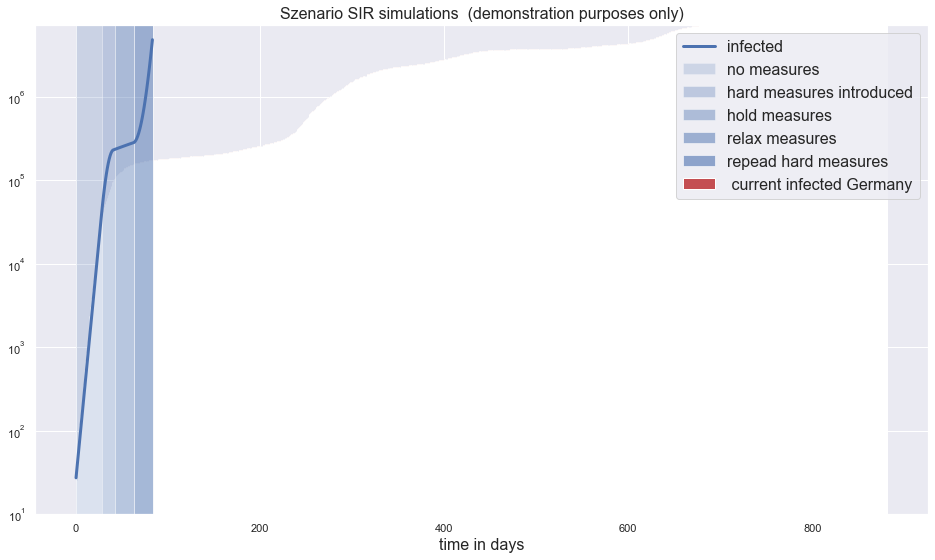

In [54]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()

ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected Germany',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='repead hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

In [75]:
## slice out some true data of a country

ydata = np.array(df_analyse.Germany[10:850])
t=np.arange(len(ydata))

In [80]:
# ensure re-initialization 
# attenion when slicing gout only a time window 
# (one Corana wave) the overall N0 is not the full popoulation size 
N0=10000000

I0=ydata[0]
S0=N0-I0
R0=0
print('start infected:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

start infected: 8
cumulative sum of invected after period 26040460
Number of days 840
N0 10000000


In [81]:
## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)

standard deviation errors :  [15.19415758 15.20803539]  start infect: 8
Optimal parameters: beta = 1.0501709566292488  and gamma =  0.9496986954912107


<ipython-input-46-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-46-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-46-16f200073f8a>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I


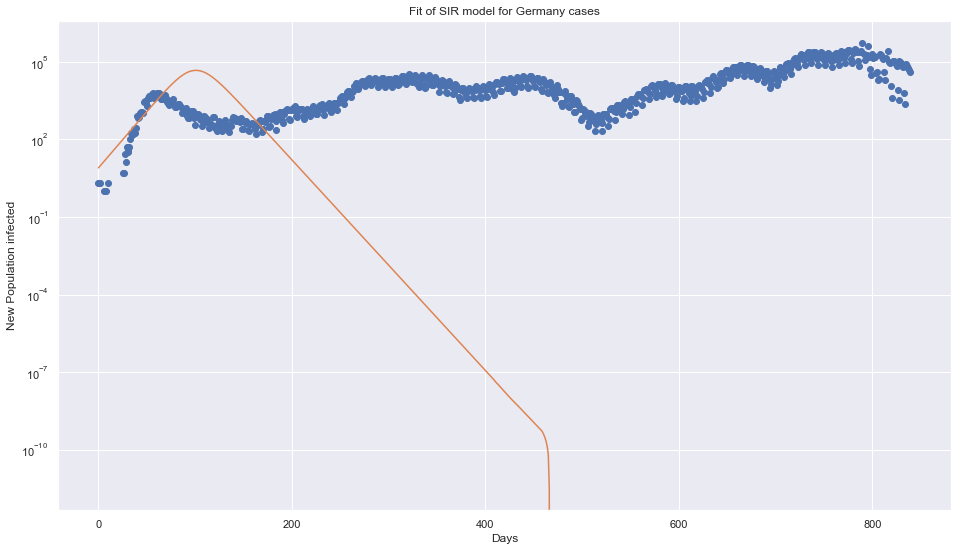

Optimal parameters: beta = 1.0501709566292488  and gamma =  0.9496986954912107
Basic Reproduction Number R0  1.1057938287322497
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a


In [82]:
# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a")